# 02. Neural network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the option)

### 1. Make classification data and get it ready

In [2]:
import sklearn
import torch

In [3]:
from sklearn.datasets import make_circles


# Make a 1000 samples
n_samples = 1000

# Create circles
X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42) #Equivalent to setting the random seed

In [4]:
len(X),len(y)

(1000, 1000)

In [5]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [6]:
# Make DataFrame of circle data

import pandas as pd

circles = pd.DataFrame({"X1":X[:,0], 
                        "X2:":X[:,1],
                         "label": y })

circles.head(10)

,X1,X2:,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


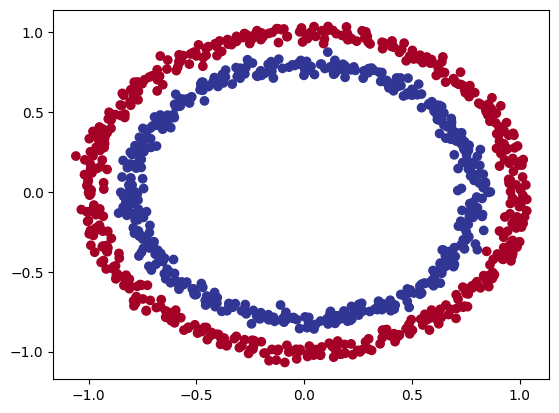

In [7]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X,y


(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         ...,
         [-0.1369, -0.8100],
         [ 0.6704, -0.7675],
         [ 0.2811,  0.9638]]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
         1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
         1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
         0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
         1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
         0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
         1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
         1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,


In [10]:
# Split the data into training and test set

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2, #0.2 = 20% of data will be test and 80% will be train
                                                 random_state=42)

### Building a model

Lets build a model to classify our blue and red dots

To do so, we want to:

1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [11]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we have setup device agnostic code lets create a model that:

1. Subclass `nn.Module` (Almost all models in PyTorch subclass nn.Module)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that ouytlines the forward pass (or forward computation) of the model
4. Instatiate an instance of our model class and send it to the target device

In [12]:
X_train.shape

torch.Size([800, 2])

In [13]:
# 1. Construct a model that subclasses nn.Module

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2,out_features=5) #Why in_features = 2 look at X.shape above #Outfeatures is the number of neurons in the hidden layer
        self.layer_2 = nn.Linear(in_features=5,out_features=1) #In_featrues here has to match the outfeatures of the layer above. Outfeature = 1 means only 1 output

    # 3. Define a forward method that outlines the forward pass
    def forward(self,x):
        return self.layer_2(self.layer_1(x)) # x-> goes into layer 1. Output of layer 1 then goes into layer 2 -> output
    
#4. Instantiate an instance of our model class 
model_0 = CircleModelV0()
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# Let's replicate the model using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)


)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1112,  0.1331],
                      [ 0.5193, -0.6959],
                      [-0.3945,  0.4044],
                      [ 0.6270,  0.7063],
                      [-0.0295,  0.3162]])),
             ('0.bias', tensor([ 0.6974, -0.2641,  0.2032,  0.1562,  0.1797])),
             ('1.weight',
              tensor([[-0.4462,  0.1812,  0.1602, -0.3178,  0.2423]])),
             ('1.bias', tensor([0.0652]))])

In [16]:
# Make predictions 
with torch.inference_mode():
    untrained_preds = model_0(X_test)
print(f"Length of predicitons: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print("\n")
print(f"Length of Test Samples: {len(X_test)}, Shape: {X_test.shape}")
print("\n")
print(f"First 10 predictions: {torch.round(untrained_preds[:10])}")
print("\n")
print(f"First 10 labels: {y_test[:10]}")


Length of predicitons: 200, Shape: torch.Size([200, 1])


Length of Test Samples: 200, Shape: torch.Size([200, 2])


First 10 predictions: tensor([[-0.],
        [-1.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-1.],
        [-0.],
        [-0.],
        [-1.]])


First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup Loss function and optimizer

Which loss function or optimizer should we use?

For Regression we miught what MAE or MSE
For classification we want binary cross entropy or categorial cross entropy

And for optimizer, two most common and useful are SGD and Adam, However PyTorch has many more options


* For the loss function we are going to use `torch.nn.BECWithLogitLoss()` 

In [17]:
loss_fn = nn.BCEWithLogitsLoss() # BCEwithLogitsLoss = sigmoid activation function built in
# loss_fn = nn.BCELoss() Requires inputs to have gone through the sigmoid activation function prior to input to BCELoss


optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [18]:
# Calculate accuracy at the same time - out of 100 example what percentage does our model get right?

def accuraacy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

### Train Model

1. Forward pass
2. Calculate the Loss
3. Zero Gradients
4. Loss backward (back propogration)
5. Optimizer (Gradient descent)


### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert this logits into prediction probabilities by passing them to some king od activation function (e.g sigmoid for binary classification and softmax for multiclass classification)

Then we can convert our model's prediction probabilites to **prediction labels** either by rounding them or taking the argmax()

In [19]:
# View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
    y_logits = model_0(X_test)[:5]
y_logits

tensor([[-0.4034],
        [-0.5271],
        [-0.0943],
        [-0.4909],
        [-0.1183]])

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [21]:
# Using the sigmoid activation function on our model logits to turn them into prediction probabilities

y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.4005],
        [0.3712],
        [0.4764],
        [0.3797],
        [0.4705]])

In [22]:
y_preds = torch.round(y_pred_prob)

#In full (Logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test)[:5]))

#Check for equality

print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))

#Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.])

### 3.2 Building a training and testing loop

In [23]:
torch.manual_seed(42)

epochs = 100

epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):

    model_0.train()

    y_logits = model_0(X_train).squeeze()

    y_pred = torch.round(torch.sigmoid(y_logits)) #Turn logits into pred probs -> pred labels


    # 2.
    loss = loss_fn(y_logits,
                   y_train)
    
    acc = accuraacy_fn(y_true=y_train,
                       y_pred = y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuraacy_fn(y_true=y_test,
                                y_pred=test_pred)
    
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Accuracy {acc} | Test Loss: {test_loss} | Test accuracy {test_acc}")
        
print(model_0.state_dict())
    

    

Epoch: 0 | Loss: 0.7078181505203247 | Accuracy 42.375 | Test Loss: 0.6998414397239685 | Test accuracy 44.0
Epoch: 10 | Loss: 0.6999485492706299 | Accuracy 45.125 | Test Loss: 0.6936880350112915 | Test accuracy 50.0
Epoch: 20 | Loss: 0.6968564391136169 | Accuracy 47.125 | Test Loss: 0.691801130771637 | Test accuracy 52.0
Epoch: 30 | Loss: 0.6954635381698608 | Accuracy 47.25 | Test Loss: 0.6913443207740784 | Test accuracy 53.5
Epoch: 40 | Loss: 0.6947304606437683 | Accuracy 48.125 | Test Loss: 0.6913745999336243 | Test accuracy 53.5
Epoch: 50 | Loss: 0.6942835450172424 | Accuracy 48.875 | Test Loss: 0.6915669441223145 | Test accuracy 53.5
Epoch: 60 | Loss: 0.6939793229103088 | Accuracy 49.375 | Test Loss: 0.6918065547943115 | Test accuracy 52.5
Epoch: 70 | Loss: 0.6937575340270996 | Accuracy 49.25 | Test Loss: 0.6920524835586548 | Test accuracy 51.0
Epoch: 80 | Loss: 0.6935896277427673 | Accuracy 49.75 | Test Loss: 0.6922898292541504 | Test accuracy 51.0
Epoch: 90 | Loss: 0.6934599280357

In [24]:
import requests
from pathlib import Path

#Download helper function

if Path("helper_functions.py").is_file():
    print("It is already installed")
else:
    print("Downloading")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)
        

from helper_functions import plot_decision_boundary

It is already installed


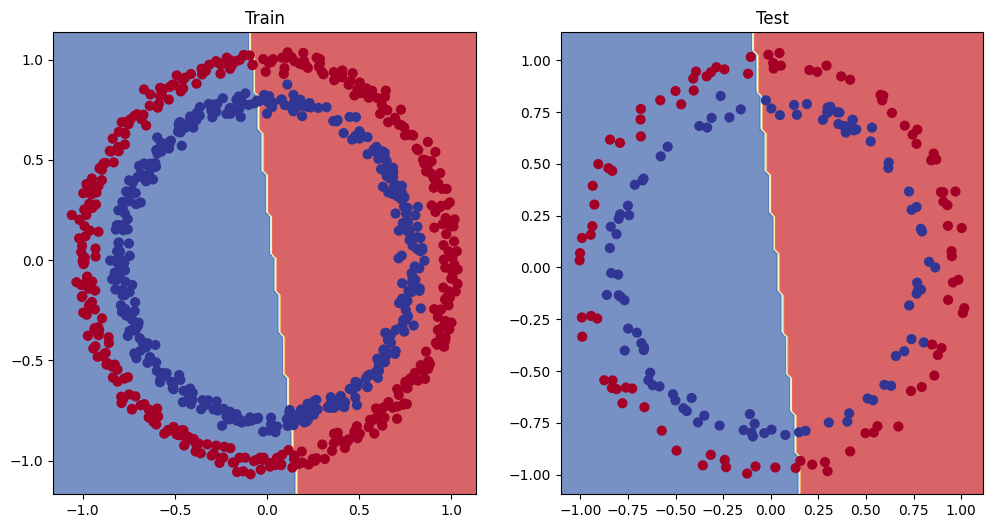

In [25]:
#Plot deciison boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

### Improving a model (from a model perspective)

* Add more layers
* Add more hidden units



In [26]:
from sklearn.datasets import make_circles


# Make a 1000 samples
n_samples = 1000

# Create circles
X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42) #Equivalent to setting the random seed

In [27]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [28]:
# Split the data into training and test set

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2, #0.2 = 20% of data will be test and 80% will be train
                                                 random_state=42)

In [ ]:

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU()

    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
        

model_1 = CircleModelV1()
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [30]:
loss_fn = nn.BCEWithLogitsLoss() # BCEwithLogitsLoss = sigmoid activation function built in
# loss_fn = nn.BCELoss() Requires inputs to have gone through the sigmoid activation function prior to input to BCELoss


optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [31]:
torch.manual_seed(42)

epochs = 2000

for epoch in range(epochs):

    model_1.train()

    y_logits = model_1(X_train).squeeze()

    y_pred = torch.round(torch.sigmoid(y_logits)) #Turn logits into pred probs -> pred labels


    # 2.
    loss = loss_fn(y_logits,
                   y_train)
    
    acc = accuraacy_fn(y_true=y_train,
                       y_pred = y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuraacy_fn(y_true=y_test,
                                y_pred=test_pred)
    
    if epoch % 100 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Accuracy {acc} | Test Loss: {test_loss} | Test accuracy {test_acc}")
        
print(model_1.state_dict())
    

    

Epoch: 0 | Loss: 0.6929463148117065 | Accuracy 50.0 | Test Loss: 0.6931881904602051 | Test accuracy 50.0
Epoch: 100 | Loss: 0.6911528706550598 | Accuracy 52.87500000000001 | Test Loss: 0.6910240054130554 | Test accuracy 52.5
Epoch: 200 | Loss: 0.6897743940353394 | Accuracy 53.37499999999999 | Test Loss: 0.6893961429595947 | Test accuracy 55.00000000000001
Epoch: 300 | Loss: 0.687949538230896 | Accuracy 53.0 | Test Loss: 0.6872316598892212 | Test accuracy 56.00000000000001
Epoch: 400 | Loss: 0.6851677894592285 | Accuracy 52.75 | Test Loss: 0.684114933013916 | Test accuracy 56.49999999999999
Epoch: 500 | Loss: 0.6810224652290344 | Accuracy 52.75 | Test Loss: 0.6794120669364929 | Test accuracy 56.49999999999999
Epoch: 600 | Loss: 0.675148606300354 | Accuracy 54.50000000000001 | Test Loss: 0.6728507876396179 | Test accuracy 56.00000000000001
Epoch: 700 | Loss: 0.6665886044502258 | Accuracy 58.375 | Test Loss: 0.6632164716720581 | Test accuracy 59.0
Epoch: 800 | Loss: 0.6515955328941345 | A

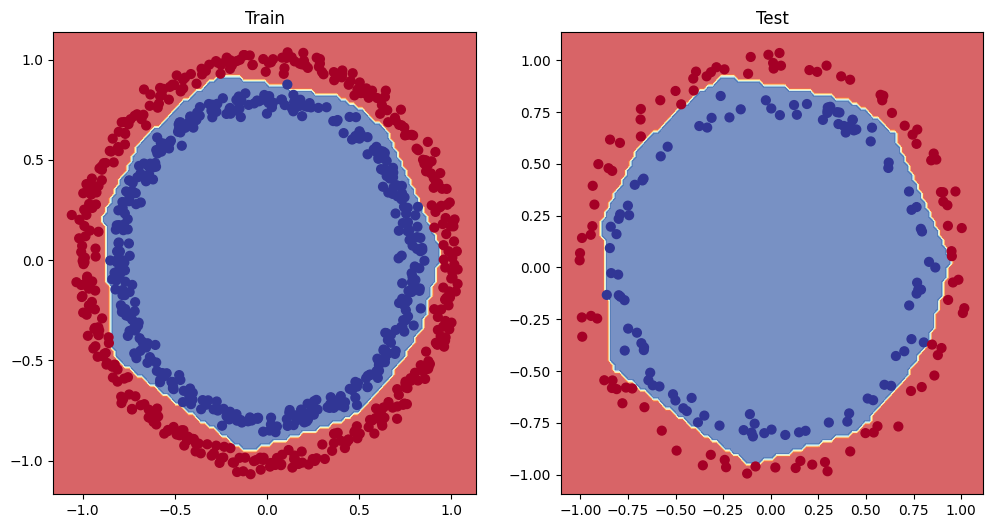

In [32]:
#Plot deciison boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

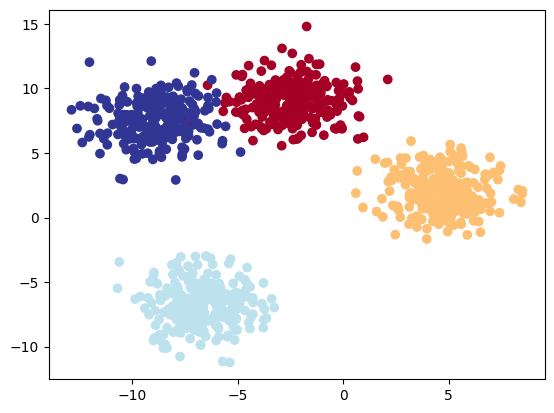

In [33]:
from sklearn.datasets import make_blobs

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob , y_blob = make_blobs(n_samples=1000,
                             n_features=NUM_FEATURES,
                             centers=NUM_CLASSES,
                             cluster_std = 1.5,
                             random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

X_blob_train,X_test_train,y_blob_train,y_blod_test = train_test_split(X_blob,
                                                                      y_blob,
                                                                      test_size=0.2,
                                                                      random_state = RANDOM_SEED)

plt.Figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

In [36]:
class BlobModelv0(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU()

    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


In [38]:
model_2 = BlobModelv0()
model_2

BlobModelv0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [42]:
loss_fn = nn.BCEWithLogitsLoss() # BCEwithLogitsLoss = sigmoid activation function built in
# loss_fn = nn.BCELoss() Requires inputs to have gone through the sigmoid activation function prior to input to BCELoss


optimizer = torch.optim.Adam(params=model_2.parameters(),
                            lr=0.1)

In [43]:
torch.manual_seed(42)

epochs = 2000

for epoch in range(epochs):

    model_2.train()

    y_logits = model_2(X_train).squeeze()

    y_pred = torch.round(torch.sigmoid(y_logits)) #Turn logits into pred probs -> pred labels


    # 2.
    loss = loss_fn(y_logits,
                   y_train)
    
    acc = accuraacy_fn(y_true=y_train,
                       y_pred = y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuraacy_fn(y_true=y_test,
                                y_pred=test_pred)
    
    if epoch % 100 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Accuracy {acc} | Test Loss: {test_loss} | Test accuracy {test_acc}")
        
print(model_2.state_dict())
    

    

Epoch: 0 | Loss: 0.10654406249523163 | Accuracy 99.875 | Test Loss: 0.7088848948478699 | Test accuracy 72.5
Epoch: 100 | Loss: 0.02418949455022812 | Accuracy 100.0 | Test Loss: 0.046580877155065536 | Test accuracy 99.5
Epoch: 200 | Loss: 0.007580569479614496 | Accuracy 100.0 | Test Loss: 0.01767708547413349 | Test accuracy 99.5
Epoch: 300 | Loss: 0.004335414618253708 | Accuracy 100.0 | Test Loss: 0.012287375517189503 | Test accuracy 99.5
Epoch: 400 | Loss: 0.0028753262013196945 | Accuracy 100.0 | Test Loss: 0.010260814800858498 | Test accuracy 99.5
Epoch: 500 | Loss: 0.0016996505437418818 | Accuracy 100.0 | Test Loss: 0.009663660079240799 | Test accuracy 99.5
Epoch: 600 | Loss: 0.0012354041682556272 | Accuracy 100.0 | Test Loss: 0.008669566363096237 | Test accuracy 99.5
Epoch: 700 | Loss: 0.0009393952786922455 | Accuracy 100.0 | Test Loss: 0.007919704541563988 | Test accuracy 99.5
Epoch: 800 | Loss: 0.0007379025919362903 | Accuracy 100.0 | Test Loss: 0.007336577400565147 | Test accurac